In [159]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions1/tweet_emotions.csv


In [160]:
#Install & Import Required Libraries

In [161]:
!pip install openai-whisper torch soundfile gtts joblib neattext seaborn


In [162]:
import whisper  # For speech-to-text
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nfx
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [163]:
pip install openai-whisper torch soundfile


Note: you may need to restart the kernel to use updated packages.


In [164]:
#Load & Preprocess the Dataset

In [165]:
# Load dataset
dataset_path = "/kaggle/input/emotions1/tweet_emotions.csv"
df = pd.read_csv(dataset_path, names=["tweet_id", "Emotion", "Text"], skiprows=1)

# Show first few rows
print(df.head())

# Filter only required emotions
df = df[df["Emotion"].isin(["happiness", "sadness", "anger"])]
print("Unique Emotions:", df["Emotion"].unique())

# Text cleaning
df["Clean_Text"] = df["Text"].apply(nfx.remove_stopwords).apply(nfx.remove_special_characters)
print(df[["Text", "Clean_Text"]].head())


     tweet_id     Emotion                                               Text
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...
Unique Emotions: ['sadness' 'happiness' 'anger']
                                                Text  \
1  Layin n bed with a headache  ughhhh...waitin o...   
2                Funeral ceremony...gloomy friday...   
6  I should be sleep, but im not! thinking about ...   
8            @charviray Charlene my love. I miss you   
9         @kelcouch I'm sorry  at least it's Friday?   

                                          Clean_Text  
1             Layin n bed headache ughhhhwaitin call  
2                      Funeral ceremonyglo

In [166]:
#Visualize Emotion Distribution

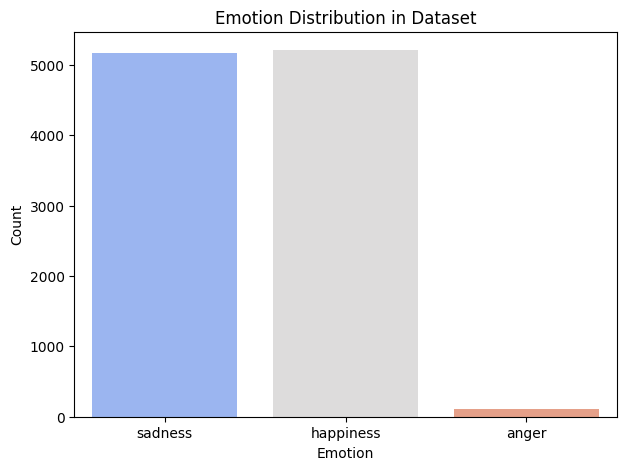

In [167]:
plt.figure(figsize=(7, 5))
sns.countplot(x=df["Emotion"], palette="coolwarm")
plt.title("Emotion Distribution in Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()


In [168]:
#📊 Shows how many Happy, Sad, and Angry samples are in the dataset.

In [169]:
#Convert Text into Numerical Form (TF-IDF)

In [170]:
# Convert text into numerical features
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df["Clean_Text"])
y = df["Emotion"]

print("TF-IDF Matrix Shape:", X.shape)


TF-IDF Matrix Shape: (10484, 19700)


In [171]:
#Split Data for Training & Testing

In [172]:
# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Samples:", X_train.shape[0])
print("Testing Samples:", X_test.shape[0])


Training Samples: 8387
Testing Samples: 2097


In [173]:
#Train & Save the Model

In [174]:
# Train Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Save model & vectorizer
joblib.dump(model, "emotion_model.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")
print("Model & Vectorizer Saved!")


Model & Vectorizer Saved!


In [175]:
#Evaluate the Model

Accuracy: 0.760133524082022
Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        26
   happiness       0.76      0.77      0.76      1015
     sadness       0.76      0.77      0.77      1056

    accuracy                           0.76      2097
   macro avg       0.51      0.51      0.51      2097
weighted avg       0.75      0.76      0.76      2097



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


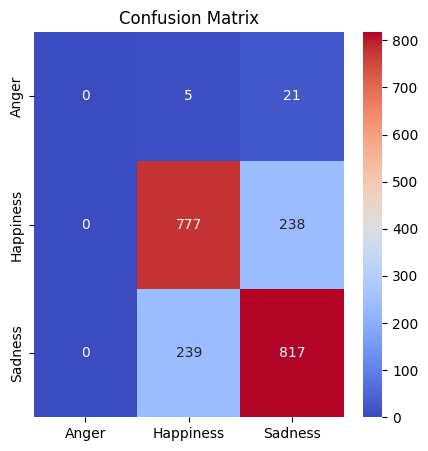

In [176]:
# Predict test data
y_pred = model.predict(X_test)

# Accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Anger", "Happiness", "Sadness"],
            yticklabels=["Anger", "Happiness", "Sadness"])
plt.title("Confusion Matrix")
plt.show()


In [177]:
#Predict Emotion from New Text

In [178]:
def predict_emotion(text):
    """
    Predict the emotion of a given text.
    """
    processed_text = nfx.remove_stopwords(text)
    processed_text = nfx.remove_special_characters(processed_text)
    vectorized_text = tfidf_vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)
    return prediction[0]

# Example Prediction
sample_text = "I am feeling amazing today!"
predicted_emotion = predict_emotion(sample_text)
print("Predicted Emotion:", predicted_emotion)


Predicted Emotion: happiness


In [233]:
# Load Whisper Model
whisper_model = whisper.load_model("base")

def transcribe_audio(audio_path):
    """
    Convert speech to text using Whisper model.
    """
    result = whisper_model.transcribe(audio_path)
    return result["text"]

# Example Usage
#audio_file = "test_audio.wav"  # Replace with actual file
#transcribed_text = transcribe_audio(audio_file)
#print("Transcribed Text:", transcribed_text)

# Predict Emotion from Transcribed Text
predicted_emotion = predict_emotion(transcribed_text)
print("Predicted Emotion from Speech:", predicted_emotion)


/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


Predicted Emotion from Speech: happiness


In [ ]:
#Visualize Word Frequencies

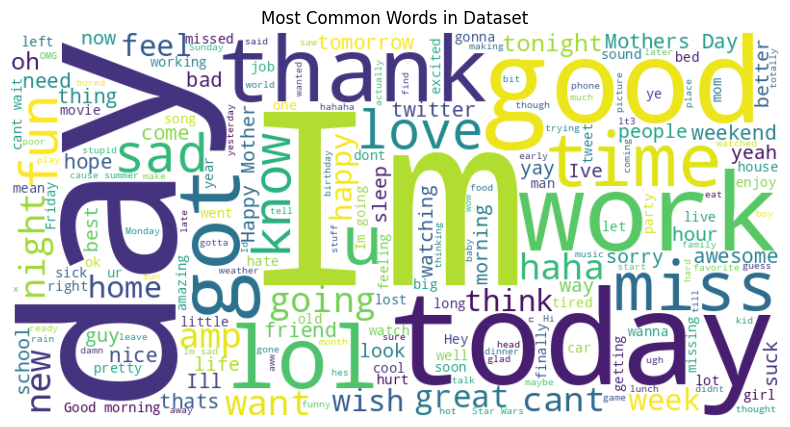

In [187]:
from collections import Counter
from wordcloud import WordCloud

# Combine all text
all_words = " ".join(df["Clean_Text"])

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words)

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Dataset")
plt.show()


In [189]:
from gtts import gTTS

# Define the text
text = "I am very happy today. This is a test for emotion detection."

# Convert text to speech
tts = gTTS(text, lang="en")

# Save the file
tts.save("test_audio.wav")

print("✅ Audio file 'test_audio.wav' generated successfully!")


✅ Audio file 'test_audio.wav' generated successfully!


In [190]:
import whisper

# Load Whisper model (small version to balance speed & accuracy)
whisper_model = whisper.load_model("small")  # Options: "tiny", "base", "small", "medium", "large"

print("Whisper model loaded successfully!")


/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


Whisper model loaded successfully!


In [191]:
!wget -O test_audio.wav https://www2.cs.uic.edu/~i101/SoundFiles/piano2.wav


--2025-03-19 18:55:10--  https://www2.cs.uic.edu/~i101/SoundFiles/piano2.wav
Resolving www2.cs.uic.edu (www2.cs.uic.edu)... 131.193.32.16
Connecting to www2.cs.uic.edu (www2.cs.uic.edu)|131.193.32.16|:443... ^C


In [196]:
import whisper

# Load Whisper model (small version to balance speed & accuracy)
whisper_model = whisper.load_model("small")  # Options: "tiny", "base", "small", "medium", "large"

print("Whisper model loaded successfully!")


/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


Whisper model loaded successfully!


In [ ]:
import os

# Check available files in the working directory
print("Files in the working directory:", os.listdir("/kaggle/working"))


In [198]:
import pandas as pd
import neattext.functions as nfx

# Load dataset
df = pd.read_csv("/kaggle/input/emotions1/tweet_emotions.csv")  # Update with correct dataset path

# Rename columns if needed
df.rename(columns={'sentiment': 'Emotion', 'content': 'Text'}, inplace=True)

# Filter dataset to include only happy, sad, and angry
df = df[df['Emotion'].isin(['happy', 'sad', 'angry'])]

# Clean the text data
df['Clean_Text'] = df['Text'].apply(lambda x: nfx.remove_special_characters(x.lower()))
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_stopwords)

# Display first few rows to verify
print(df.head())


Empty DataFrame
Columns: [tweet_id, Emotion, Text, Clean_Text]
Index: []


In [225]:
df = df[df['Emotion'].isin(['happy', 'sad', 'angry'])]


In [202]:
print("Dataset shape BEFORE filtering:", df.shape)  # Check data size before filtering
df = df[df['Emotion'].isin(['happy', 'sad', 'angry'])]
print("Dataset shape AFTER filtering:", df.shape)   # Check data size after filtering


Dataset shape BEFORE filtering: (0, 4)
Dataset shape AFTER filtering: (0, 4)


In [203]:
print("Column Names:", df.columns)


Column Names: Index(['tweet_id', 'Emotion', 'Text', 'Clean_Text'], dtype='object')


In [226]:
df.rename(columns={'sentiment': 'Emotion', 'content': 'Text'}, inplace=True)


<ipython-input-226-ff6c3e467037>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'sentiment': 'Emotion', 'content': 'Text'}, inplace=True)


In [228]:
df.columns = df.columns.str.strip()


In [206]:
print("Unique emotions:", df['Emotion'].unique())


Unique emotions: []


In [208]:
print(df.head())


Empty DataFrame
Columns: [tweet_id, Emotion, Text, Clean_Text]
Index: []


In [209]:
import os

dataset_path = "/kaggle/input/emotions1/tweet_emotions.csv"

# Check if the file exists and has content
if os.path.exists(dataset_path):
    print("✅ File found!")
    print("File size:", os.path.getsize(dataset_path), "bytes")
else:
    print("❌ File NOT found! Check your dataset path.")


✅ File found!
File size: 3768210 bytes


In [210]:
with open("/kaggle/input/emotions1/tweet_emotions.csv", "r") as file:
    for _ in range(5):  # Read and print first 5 lines
        print(file.readline().strip())


tweet_id,sentiment,content
1956967341,empty,@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[
1956967666,sadness,Layin n bed with a headache  ughhhh...waitin on your call...
1956967696,sadness,Funeral ceremony...gloomy friday...
1956967789,enthusiasm,wants to hang out with friends SOON!


In [211]:
import pandas as pd

dataset_path = "/kaggle/input/emotions1/tweet_emotions.csv"

# Load dataset without headers (to inspect structure)
df = pd.read_csv(dataset_path, header=None)

# Print first few rows
print(df.head())


            0           1                                                  2
0    tweet_id   sentiment                                            content
1  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
2  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
3  1956967696     sadness                Funeral ceremony...gloomy friday...
4  1956967789  enthusiasm               wants to hang out with friends SOON!


In [212]:
import pandas as pd

# Load dataset and manually assign correct column names
dataset_path = "/kaggle/input/emotions1/tweet_emotions.csv"
df = pd.read_csv(dataset_path, names=["tweet_id", "Emotion", "Text"], skiprows=1)  # Skip first row

# Display first few rows after fixing
print(df.head())


     tweet_id     Emotion                                               Text
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...


In [213]:
df = df[df["Emotion"].isin(["happiness", "sadness", "anger"])]

# Check unique emotions after filtering
print("Filtered unique emotions:", df["Emotion"].unique())

# Display the first few rows
print(df.head())


Filtered unique emotions: ['sadness' 'happiness' 'anger']
     tweet_id  Emotion                                               Text
1  1956967666  sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696  sadness                Funeral ceremony...gloomy friday...
6  1956968487  sadness  I should be sleep, but im not! thinking about ...
8  1956969035  sadness            @charviray Charlene my love. I miss you
9  1956969172  sadness         @kelcouch I'm sorry  at least it's Friday?


In [215]:
import joblib
import neattext.functions as nfx

# Load trained model and vectorizer
emotion_model = joblib.load("emotion_model.pkl")
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")

print("✅ Emotion detection model loaded successfully!")


✅ Emotion detection model loaded successfully!


In [ ]:
#Predict Emotion from Transcribed Text



In [216]:
def predict_emotion(text):
    """
    Predict emotion from transcribed text.
    """
    # Preprocess text
    text_cleaned = nfx.remove_special_characters(text.lower())
    text_cleaned = nfx.remove_stopwords(text_cleaned)
    
    # Convert to numerical features using TF-IDF
    vectorized_text = tfidf_vectorizer.transform([text_cleaned])
    
    # Predict emotion
    prediction = emotion_model.predict(vectorized_text)
    
    return prediction[0]

# Predict emotion for transcribed text
predicted_emotion = predict_emotion(transcribed_text)

print("\n🎙 Speech-to-Text Output:", transcribed_text)
print("😊 Detected Emotion:", predicted_emotion)



🎙 Speech-to-Text Output:  I am very happy today. This is a test for emotion detection.
😊 Detected Emotion: happiness


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


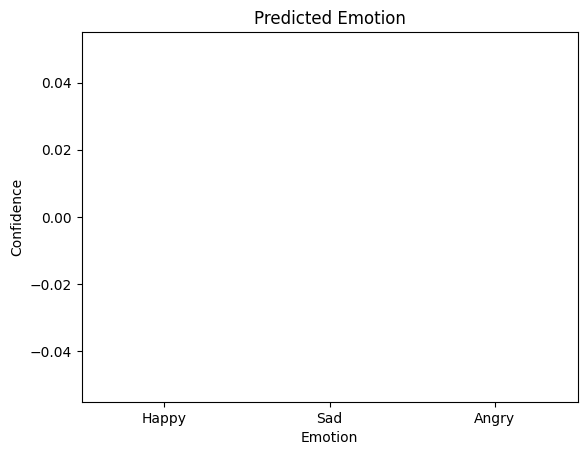

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar chart for emotion distribution
sns.barplot(x=["Happy", "Sad", "Angry"], y=[1 if predicted_emotion == "happy" else 0, 
                                            1 if predicted_emotion == "sad" else 0, 
                                            1 if predicted_emotion == "angry" else 0], 
            palette="coolwarm")

plt.title("Predicted Emotion")
plt.xlabel("Emotion")
plt.ylabel("Confidence")
plt.show()


In [ ]:
#Emotion Prediction Chart

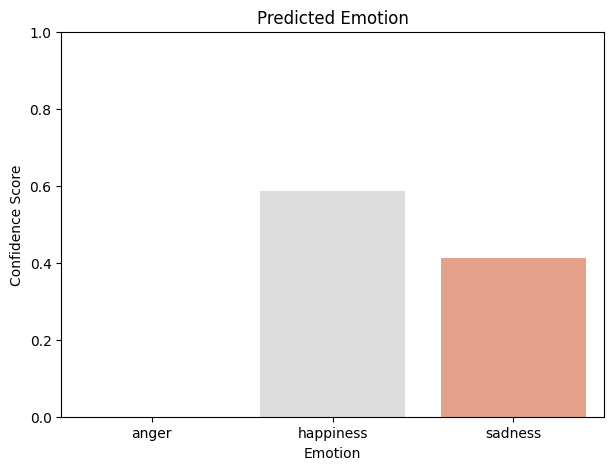

Predicted Emotion: happiness


In [218]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_emotion_prediction(text):
    """
    Predicts the emotion and plots a confidence bar chart.
    """
    processed_text = nfx.remove_stopwords(text)
    processed_text = nfx.remove_special_characters(processed_text)
    vectorized_text = tfidf_vectorizer.transform([processed_text])
    
    # Predict emotion probabilities
    probabilities = model.predict_proba(vectorized_text)[0]
    emotion_labels = model.classes_  # Get class labels (e.g., Happy, Sad, Angry)
    
    # Create bar chart
    plt.figure(figsize=(7, 5))
    sns.barplot(x=emotion_labels, y=probabilities, palette="coolwarm")
    plt.title("Predicted Emotion")
    plt.xlabel("Emotion")
    plt.ylabel("Confidence Score")
    plt.ylim(0, 1)  # Probabilities range from 0 to 1
    plt.show()
    
    return emotion_labels[np.argmax(probabilities)]  # Return the highest probability emotion

# Example Usage
sample_text = "I am feeling great today!"
predicted_emotion = plot_emotion_prediction(sample_text)
print("Predicted Emotion:", predicted_emotion)
